# Handwritten Digits Recognition Using Shallow Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [2]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [3]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[8. 2. 0. 1. 4. 8. 0. 3. 7. 9.]


In [4]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [5]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [6]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
8.0
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


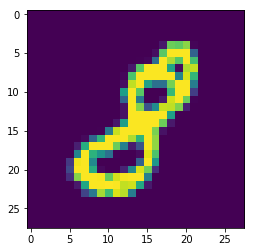

In [7]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [8]:
train_ratio = 0.9

In [9]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [14]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

def softmax(z):
    t = np.exp(z)
    n = np.sum(t, axis = 0)
    a = t/n
    return a

In [15]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = np.sum(-Y*np.log(Y_hat+delta), axis=0)
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(softmax)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(None)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [16]:
def loss_function_for__config_multi_layer_classifier_with_dropout_regularization(Y_hat, Y):
    delta = 1e-10
    l = np.sum(-Y*np.log(Y_hat+delta), axis=0)
    return l

def forward_propagation_for_config_multi_layer_classifier_with_dropout_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    keep_prob = model['keep_prob']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
        dropout = np.random.uniform(0.0, 1.0, A[i].shape)
        dropout = dropout < keep_prob[i]
        A[i] = A[i] * dropout
        A[i] = A[i] / keep_prob[i]
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_with_dropout_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_with_dropout_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_with_dropout_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_with_dropout_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    keep_prob = [1] + [0.8 for i in range(L-1)] + [1]
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(softmax)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(None)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_with_dropout_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['keep_prob'] = keep_prob
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_with_dropout_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_with_dropout_regularization
    model['update'] = update_for_config_multi_layer_classifier_with_dropout_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_with_dropout_regularization
    
    return model

In [17]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [20]:
model = config_multi_layer_classifier_with_dropout_regularization(train_X, train_Y, [28, 28, 28, 28], 0.8)

iteration 0, current loss: 320283.879765
iteration 1, current loss: 284157.168449
iteration 2, current loss: 261337.307949
iteration 3, current loss: 242979.756056
iteration 4, current loss: 227928.286495
iteration 5, current loss: 217180.960272
iteration 6, current loss: 209039.448701
iteration 7, current loss: 198827.730288
iteration 8, current loss: 191039.174592
iteration 9, current loss: 184825.038046
iteration 10, current loss: 180564.125331
iteration 11, current loss: 173542.481128
iteration 12, current loss: 168786.780512
iteration 13, current loss: 164274.115863
iteration 14, current loss: 160829.255922
iteration 15, current loss: 156377.481091
iteration 16, current loss: 152055.534791
iteration 17, current loss: 148971.209516
iteration 18, current loss: 145764.262671
iteration 19, current loss: 142885.106828
iteration 20, current loss: 139663.780946
iteration 21, current loss: 137367.182320
iteration 22, current loss: 133855.854242
iteration 23, current loss: 132596.458168
it

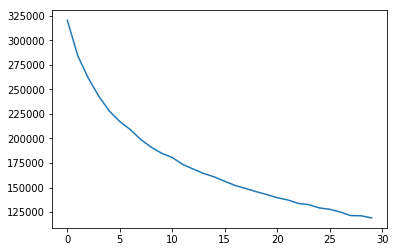

In [21]:
train_model(30, model)
costs = model['costs']
plt.plot(costs[-30:])
#print(W[1])

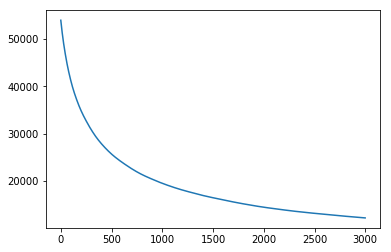

In [73]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [18]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [31]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.884841
test set accuracy: 0.842381


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [79]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [80]:
test_Y = predict(test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [81]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [82]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

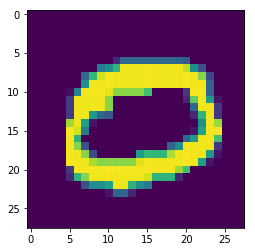

In [83]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])